## Lab 2
### Part 2: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [ ]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')
        
root_path = 'fmnist'
mkdir(root_path)

Directory fmnist is created!


In [ ]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path, 
                                                        train=True, 
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path, 
                                                       train=False, 
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting fmnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to fmnist/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting fmnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to fmnist/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting fmnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to fmnist/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting fmnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to fmnist/FashionMNIST/raw



In [ ]:
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train, 
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)

In [ ]:
len(fmnist_dataset_test)

10000

In [ ]:
for img, label in train_loader:
    print(img.shape)
#     print(img)
    print(label.shape)
    print(label.size(0))
    break

torch.Size([128, 1, 28, 28])
torch.Size([128])
128


### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [ ]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 24*24),
            nn.BatchNorm1d(24*24),
            nn.ELU(),
            nn.Linear(24*24, 20*20),
            nn.BatchNorm1d(20*20),
            nn.ELU(),
            nn.Linear(20*20, 10),
            nn.LogSoftmax()
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [ ]:
torchsummary.summary(TinyNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 576]         452,160
       BatchNorm1d-3                  [-1, 576]           1,152
               ELU-4                  [-1, 576]               0
            Linear-5                  [-1, 400]         230,800
       BatchNorm1d-6                  [-1, 400]             800
               ELU-7                  [-1, 400]               0
            Linear-8                   [-1, 10]           4,010
        LogSoftmax-9                   [-1, 10]               0
Total params: 688,922
Trainable params: 688,922
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.03
Params size (MB): 2.63
Estimated Total Size (MB): 2.66
-------------------------------------------

Your experiments come here:

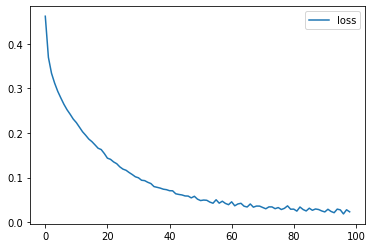

In [ ]:
model = TinyNeuralNetwork().to(device)
opt = torch.optim.AdamW(model.parameters()) # YOUR CODE HERE
loss_func = nn.CrossEntropyLoss() # YOUR CODE HERE
n_epochs = 100
history = {}

# Your experiments, training and validation loops here
for i in range(n_epochs):
  history[i] = []
  for image, label in train_loader:
    x = image.reshape(image.shape[0], -1).to('cuda:0')
    logits = model(x)
    loss = loss_func(logits, label.to('cuda:0'))
    history[i].append(loss.detach().cpu().numpy())

    loss.backward()
    opt.step()
    opt.zero_grad()

  if (i + 1) % 20 == 0: 
    clear_output(True)
    history_mean = [sum(losses)/len(losses) for losses in history.values()]
    plt.plot(history_mean,label='loss')
    plt.legend()
    plt.show()

    

In [ ]:
import torch.nn.functional as F

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
acc_history = []
with torch.no_grad():
  for image, label in test_loader:
    x = image.reshape(image.shape[0], -1).to('cuda:0')
    logits = model(x)
    probas = F.softmax(logits, dim = -1)
    probas = probas.detach().cpu().numpy()
    y_pred = np.argmax(probas, axis = -1)
    current_acc = accuracy_score(label.detach().numpy(), y_pred)
    acc_history.append(current_acc)

In [ ]:
np.array(acc_history).mean()

0.89345703125

### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

In [ ]:
from torch.nn.modules.activation import LogSoftmax
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, input_shape*2),
            nn.ELU(),
            nn.Linear(input_shape*2, num_classes),
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return torch.nn.functional.log_softmax(out, dim = -1)

In [ ]:
torchsummary.summary(OverfittingNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                 [-1, 1568]       1,230,880
               ELU-3                 [-1, 1568]               0
            Linear-4                   [-1, 10]          15,690
Total params: 1,246,570
Trainable params: 1,246,570
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.03
Params size (MB): 4.76
Estimated Total Size (MB): 4.79
----------------------------------------------------------------


In [ ]:
def loop(model, data_loader, loss_func, opt = None, is_train = True):
  acc_history = []
  history = []
  for image, label in data_loader:
    x = image.reshape(image.shape[0], -1).to('cuda:0')
    logits = model(x)
    loss = loss_func(logits, label.to('cuda:0'))
    history.append(loss.detach().cpu().numpy())
    
    probas = F.softmax(logits, dim = -1)
    probas = probas.detach().cpu().numpy()
    y_pred = np.argmax(probas, axis = -1)
    current_acc = accuracy_score(label.detach().numpy(), y_pred)
    acc_history.append(current_acc)

    if is_train:
      loss.backward()
      opt.step()
      opt.zero_grad()
      
  mean_acc = np.array(acc_history).mean()
  mean_loss = np.array(history).mean()
  return mean_loss, mean_acc

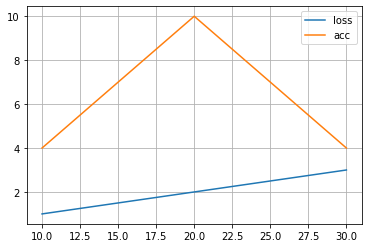

In [ ]:
x = [10, 20, 30]
plt.plot(range(10, 31, 10), [1, 2, 3], label = 'loss')
plt.plot(range(10, 31, 10), [4, 10, 4], label = 'acc')
plt.legend()
plt.grid()
plt.show()

In [ ]:
train_loader

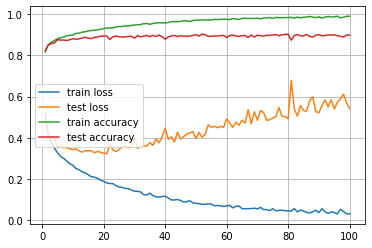

In [ ]:
model = OverfittingNeuralNetwork().to(device)
opt = torch.optim.AdamW(model.parameters()) # YOUR CODE HERE
loss_func = nn.CrossEntropyLoss() # YOUR CODE HERE
epochs = 100
# Your experiments, come here
train_losses = []
test_losses = []
train_accs = []
test_accs = []
for i in range(epochs):
  train_loss, train_acc = loop(model, train_loader, loss_func, opt = opt)
  model.eval()
    with torch.no_grad():
        test_loss, test_acc = loop(model, test_dataloader, loss_func=loss_func)
  model.train()
  train_losses.append(train_loss)
  train_accs.append(train_acc)
  test_losses.append(test_loss)
  test_accs.append(test_acc)
  if (i+1)%10 == 0:
    x = range(1, i+2, 1)

    clear_output(True)
    plt.plot(x, train_losses, label='train loss')
    plt.plot(x, test_losses, label='test loss')
    plt.plot(x, train_accs, label='train accuracy')
    plt.plot(x, test_accs, label='test accuracy')
    plt.grid()
    plt.legend()
    plt.show()

In [ ]:
train_losses

[0.8149986673773987,
 0.8518456823027718,
 0.8602078891257996,
 0.8688033049040512,
 0.876849013859275,
 0.8812633262260128,
 0.8873600746268657,
 0.8943785536602701,
 0.8959443852167733,
 0.8973936122956646]

### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results. 

In [ ]:
from torch.nn.modules.dropout import Dropout
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, input_shape*2),
            nn.BatchNorm1d(input_shape*2),
            nn.ELU(),
            nn.Dropout(),
            nn.Linear(input_shape*2, num_classes),
            nn.BatchNorm1d(num_classes)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return torch.nn.functional.log_softmax(out, dim = -1)

In [ ]:
torchsummary.summary(FixedNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                 [-1, 1568]       1,230,880
       BatchNorm1d-3                 [-1, 1568]           3,136
               ELU-4                 [-1, 1568]               0
           Dropout-5                 [-1, 1568]               0
            Linear-6                   [-1, 10]          15,690
       BatchNorm1d-7                   [-1, 10]              20
Total params: 1,249,726
Trainable params: 1,249,726
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.05
Params size (MB): 4.77
Estimated Total Size (MB): 4.82
----------------------------------------------------------------


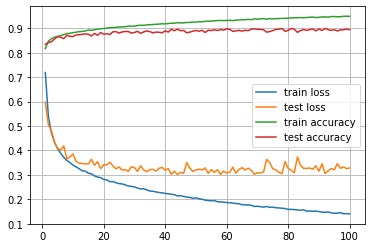

In [ ]:
model = FixedNeuralNetwork().to(device)
opt = torch.optim.AdamW(model.parameters()) # YOUR CODE HERE
loss_func = nn.CrossEntropyLoss() # YOUR CODE HERE
epochs = 100
# Your experiments, come here
train_losses = []
test_losses = []
train_accs = []
test_accs = []
for i in range(epochs):
  train_loss, train_acc = loop(model, train_loader, loss_func, opt = opt)
  model.eval()
  with torch.no_grad():
    test_loss, test_acc = loop(model, test_loader, loss_func, is_train = False)
  model.train()
  train_losses.append(train_loss)
  train_accs.append(train_acc)
  test_losses.append(test_loss)
  test_accs.append(test_acc)
  if (i+1)%10 == 0:
    x = range(1, i+2, 1)

    clear_output(True)
    plt.plot(x, train_losses, label='train loss')
    plt.plot(x, test_losses, label='test loss')
    plt.plot(x, train_accs, label='train accuracy')
    plt.plot(x, test_accs, label='test accuracy')
    plt.grid()
    plt.legend()
    plt.show()

### Conclusions:
_Write down small report with your conclusions and your ideas._

Мне показалось, что даже для неглубокой сети получить проблемы переобучения довольно легко, если сделать модель в ширь, не делая её глубокой. Хотя, кажется, очевидно. Но труда это не составило.

Видно, что BatchNorm очень хорошо помогает с переобучением. Как мы видим во втором случае лосс не падает прям к 0, а train accuracy не находится столь близко, как без нормализации. При этом test loss имеет gap меньше (около 0.18 при нормализации, а без около 0.55) с train loss и само значение test loss меньше. Также accuracy при нормализации на test лучше, чем без нормализации и при этом довольно значительный (0.9 против 0.82). Поэтому батчнорм может сильно помочь, но полностью не спасёт от бесконечного повышения, т.к. видно, что  все равно достигаем некоторого плато, но более высокого accuracy и меньшего Loss  